In [76]:
library(MASS)
library(rpart)
library(caret)
library(rpart)
library(class)

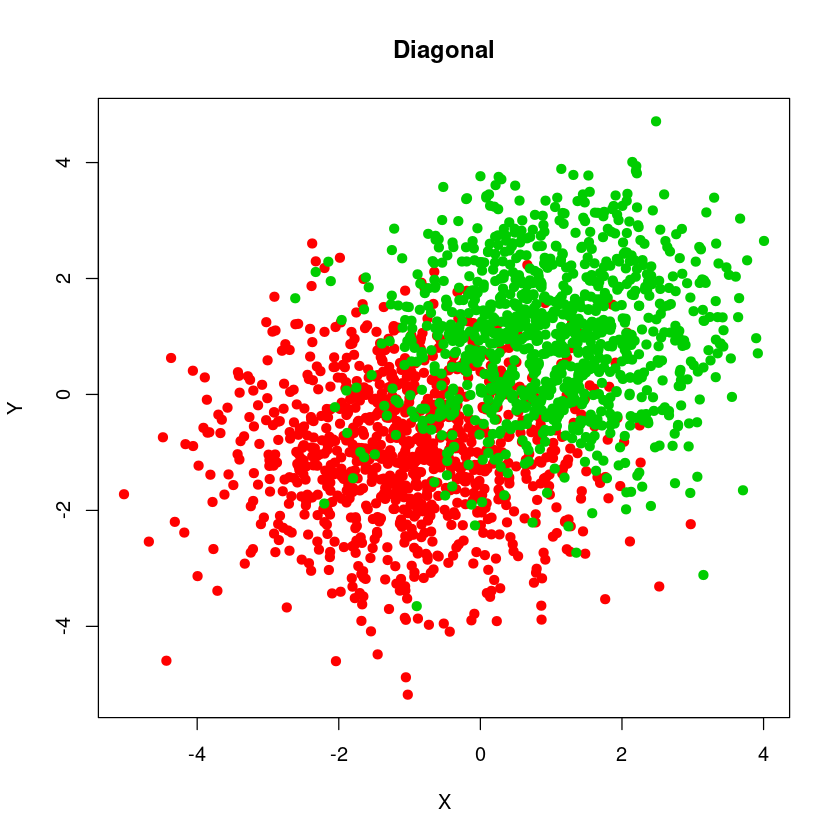

In [77]:
create_points_diagonal = function(d, n, C) {
  center0 = rep(-1, d)
  center1 = rep(1, d)
  cov = diag(rep(C*sqrt(d)**2, d))
  mid = n / 2

  # Generate random points
  class0_ = mvrnorm(mid, center0, cov)
  class1_ = mvrnorm(n-mid, center1, cov)

  class0 = cbind(class0_, rep(1, mid))
  class1 = cbind(class1_, rep(2, n-mid))

  df = data.frame(rbind(class0, class1), row.names = NULL, check.rows = FALSE)
  colnames(df) = c(paste0("x", 1:d), "CLASS")

  return (df)
}

df = create_points_diagonal(2, 2000, .75)
plot(df[,1], df[,2], col=df$CLASS+1, pch=19, xlab="X", ylab="Y", main="Diagonal")

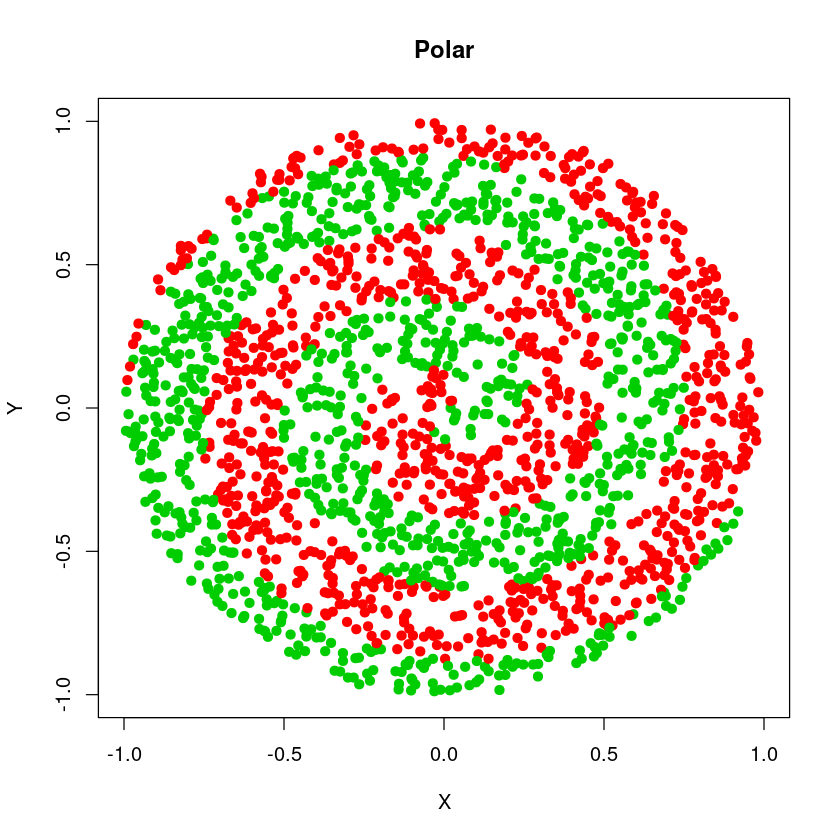

In [78]:
create_polars_points = function(n, r) {
  ro = sqrt(runif(n)) * r
  theta = runif(n) * (2*pi)
  df = data.frame(ro, theta)
}

classify_polars_points = function(df) {
  fun1 = function(t) {
    return (t/(4 * pi))
  }

  fun2 = function(t) {
    return ((t + pi)/(4 * pi))
  }

  condition = function(t, r) {
    return ((fun1(t) <= r && r <= fun2(t))
            || (fun1(t+2*pi) <= r && r <= fun2(t+2*pi))
            || (fun1(t-2*pi) <= r && r <= fun2(t-2*pi)))
  }
  
  df$CLASS = 1
  for (i in 1:nrow(df)) {
    if (condition(df$theta[i], df$ro[i])) {
      df$CLASS[i] = 2
    }
  }

  return (df)
}

create_espiral_points = function(n, r) {
  df = create_polars_points(n, r)
  classify_polars_points(df)
}

plot_polars_points = function(df, r) {
  plot(df$ro*cos(df$theta), df$ro*sin(df$theta), col=df$CLASS+1, pch=19, xlab="X", ylab="Y", main="Polar", xlim=c(-r, r), ylim=c(-r, r))
}

df = create_espiral_points(2000, 1)
plot_polars_points(df, 1)

In [154]:
diag_train_set = create_points_diagonal(2, 200, .5)
diag_test_set = create_points_diagonal(2, 2000, .5)

espiral_train_set = create_espiral_points(200, 1)
espiral_test_set = create_espiral_points(2000, 1)

k = 5
fold_diag_train_set = createFolds(t(diag_train_set$CLASS), k=k)

# Decision Tree

         
diag_pred   1   2
        1 916 149
        2  84 851


[1] "Error:  0.116500"

            
espiral_pred   1   2
           1 546 171
           2 435 848


[1] "Error:  0.303000"

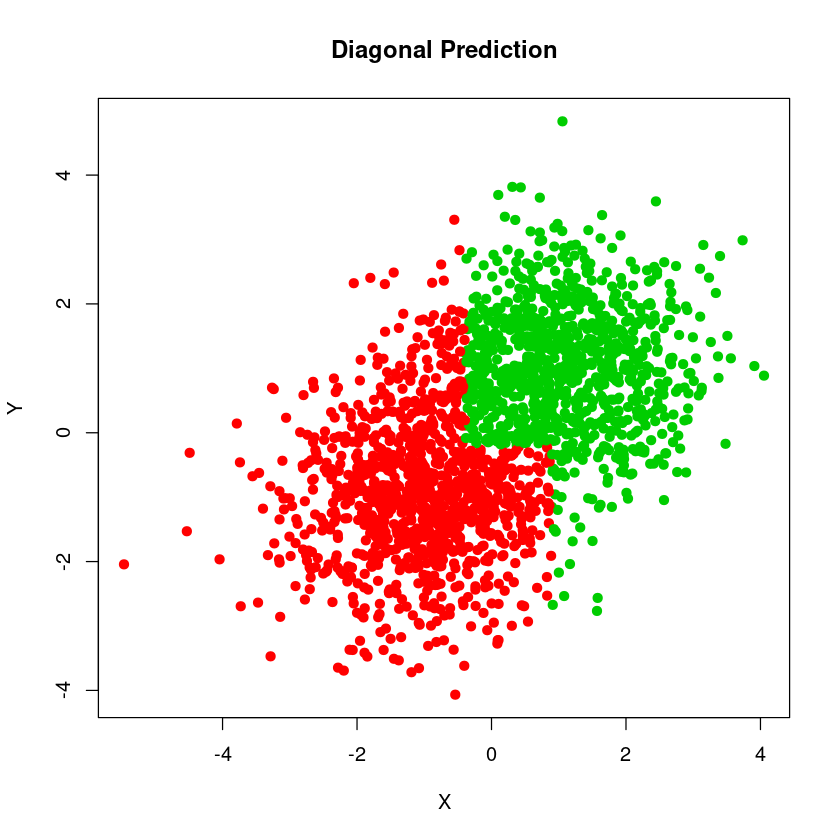

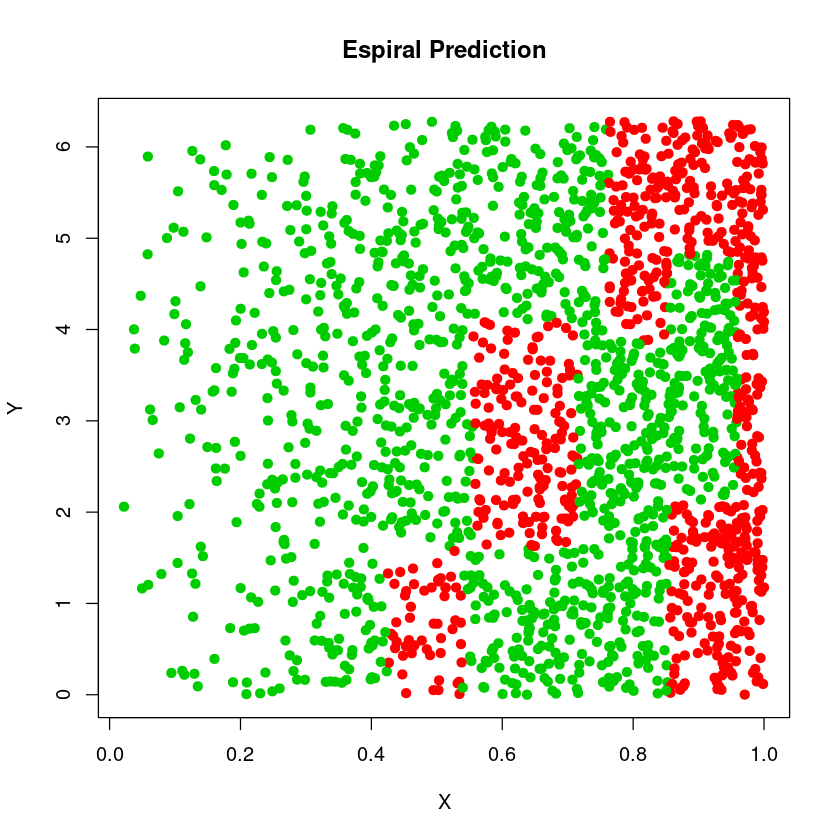

In [155]:
diag_tree = rpart(CLASS ~ ., data=diag_train_set, method="class")
diag_pred = predict(diag_tree, diag_test_set[-3], type="class")
diag_matrix = table(diag_pred, diag_test_set$CLASS)
print(diag_matrix)
diag_error = 1 - sum(diag(diag_matrix))/sum(diag_matrix)
sprintf("Error: % f", diag_error)
p_df = diag_test_set[-3]
p_df$CLASS = as.numeric(diag_pred)
plot(p_df[,1], p_df[,2], col=p_df$CLASS+1, pch=19, xlab="X", ylab="Y", main="Diagonal Prediction")

espiral_tree = rpart(CLASS ~ ., data=espiral_train_set, method="class")
espiral_pred = predict(espiral_tree, espiral_test_set[-3], type="class")
espiral_matrix = table(espiral_pred, espiral_test_set$CLASS)
print(espiral_matrix)
espiral_error = 1 - sum(diag(espiral_matrix))/sum(espiral_matrix)
sprintf("Error: % f", espiral_error)
p_df = espiral_test_set[-3]
p_df$CLASS = as.numeric(espiral_pred)
plot(p_df[,1], p_df[,2], col=p_df$CLASS+1, pch=19, xlab="X", ylab="Y", main="Espiral Prediction")

In [156]:
diag_errors = c()
espiral_errors = c()

for (i in 1:k) {
  diag_train = diag_train_set[setdiff(seq(1 : dim(diag_train_set)[1]), fold_diag_train_set[[i]]),]
  diag_test = diag_train_set[fold_diag_train_set[[i]],]
  diag_tree = rpart(CLASS ~ ., data=diag_train, method="class")
  diag_pred = predict(diag_tree, diag_test[-3], type="class")
  diag_matrix = table(diag_pred, diag_test$CLASS)
  diag_error = 1 - sum(diag(diag_matrix))/sum(diag_matrix)
  diag_errors = c(diag_errors, diag_error)

  espiral_train = espiral_train_set[setdiff(seq(1 : dim(espiral_train_set)[1]), fold_espiral_train_set[[i]]),]
  espiral_test = espiral_train_set[fold_espiral_train_set[[i]],]
  espiral_tree = rpart(CLASS ~ ., data=espiral_train, method="class")
  espiral_pred = predict(espiral_tree, espiral_test[-3], type="class")
  espiral_matrix = table(espiral_pred, espiral_test$CLASS)
  espiral_error = 1 - sum(diag(espiral_matrix))/sum(espiral_matrix)
  espiral_errors = c(espiral_errors, espiral_error)
}

sprintf("Diagonal Error: % f", mean(diag_errors))
sprintf("Espiral Error: % f", mean(espiral_errors))

[1] "Diagonal Error:  0.095000"

[1] "Espiral Error:  0.375000"

# Conclusion
Como ya sabiamos, el arbol de desicion no es el mejor modelo para resolver el problema de espirales, especialmente si le pasamos tan pocos datos de entrenamiento. Tambien el modelo no mejor al hacer cross-validation

Por otro lado, el modelo es mejor para el problema diagonal, y si mejora un poco con cross-validation, por lo que es mejor usar DT para el problema de diagonal.

# K Nearest Neighbor

In [151]:
diag_knn_model = knn(train=diag_train_set[-3], test=diag_test_set[-3], cl=diag_train_set$CLASS, k=1)
diag_knn_matrix = table(diag_knn_model, diag_test_set$CLASS)
print(diag_knn_matrix)
diag_knn_error = 1 - sum(diag(diag_knn_matrix))/sum(diag_knn_matrix)
sprintf("Diagonal Error: % f", diag_knn_error)

espiral_knn_model = knn(train=espiral_train_set[-3], test=espiral_test_set[-3], cl=espiral_train_set$CLASS, k=1)
espiral_knn_matrix = table(espiral_knn_model, espiral_test_set$CLASS)
print(espiral_knn_matrix)
espiral_knn_error = 1 - sum(diag(espiral_knn_matrix))/sum(espiral_knn_matrix)
sprintf("Espiral Error: % f", espiral_knn_error)

              
diag_knn_model   1   2
             1 854  84
             2 146 916


[1] "Diagonal Error:  0.115000"

                 
espiral_knn_model   1   2
                1 834 215
                2 187 764


[1] "Espiral Error:  0.201000"

In [152]:
diag_errors = c()
espiral_errors = c()

for (i in 1:k) {
  diag_train = diag_train_set[setdiff(seq(1 : dim(diag_train_set)[1]), fold_diag_train_set[[i]]),]
  diag_test = diag_train_set[fold_diag_train_set[[i]],]
  diag_knn = knn(train=diag_train[-3], test=diag_test[-3], cl=diag_train[,3], k=1)
  diag_matrix = table(diag_knn, diag_test$CLASS)
  diag_error = 1 - sum(diag(diag_matrix))/sum(diag_matrix)
  diag_errors = c(diag_errors, diag_error)

  espiral_train = espiral_train_set[setdiff(seq(1 : dim(espiral_train_set)[1]), fold_espiral_train_set[[i]]),]
  espiral_test = espiral_train_set[fold_espiral_train_set[[i]],]
  espiral_knn = knn(train=espiral_train[-3], test=espiral_test[-3], cl=espiral_train[,3], k=1)
  espiral_matrix = table(espiral_knn, espiral_test$CLASS)
  espiral_error = 1 - sum(diag(espiral_matrix))/sum(espiral_matrix)
  espiral_errors = c(espiral_errors, espiral_error)
}

sprintf("Diagonal Error: % f", mean(diag_errors))
sprintf("Espiral Error: % f", mean(espiral_errors))

[1] "Diagonal Error:  0.120000"

[1] "Espiral Error:  0.295000"

# Conclusiones
KNN es notablemente mejor modelo para el problema de espirales, pero no mejora mucho haciendo cross-validation. Por otro lado, para el problema de diagonal, KNN es peor que DT, y no mejora mucho haciendo cross-validation. Y de esta forma concluimos que el modelo de KNN con cross-validation es mejor para resolver el porblema de espirales, especialmente si le damos mas datos para entrenar.